# EDA

1. __Cargar los datos__

In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

<span style="color:pink">Definir la ruta del archivo y cargar dataset</span>


In [468]:
file_path = "../data/train_test/attrition_availabledata_29.csv"
df = pd.read_csv(file_path)

2. __Información general del dataset__

<span style="color:pink"> Ver las primeras filas del dataset</span>

In [469]:
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,7.462297,13,3,3,3.0,3.0,3.0,48,Travel_Rarely,Research & Development,...,Y,13,8,1,18.0,2,8,7,7,No
1,7.488597,6,1,3,3.0,4.0,4.0,31,Travel_Frequently,Research & Development,...,Y,17,8,1,3.0,2,1,0,0,Yes
2,7.116541,16,2,4,1.0,1.0,3.0,36,Travel_Rarely,Research & Development,...,Y,24,8,0,6.0,6,5,0,3,No
3,9.709125,6,3,4,3.0,3.0,3.0,49,Travel_Rarely,Research & Development,...,Y,22,8,0,25.0,2,7,0,7,No
4,6.297729,6,4,3,3.0,2.0,3.0,40,Travel_Frequently,Research & Development,...,Y,13,8,1,8.0,3,8,3,7,No


<span style="color:pink">Información general sobre las variables</span>

In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2925 non-null   float64
 5   JobSatisfaction          2928 non-null   float64
 6   WorkLifeBalance          2911 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID              

3. __identificar el numero de variables e instancias__

In [471]:
num_filas, num_columnas = df.shape
print(f"Número de instancias: {num_filas}")
print(f"Número de variables: {num_columnas}")

Número de instancias: 2940
Número de variables: 31


4. __Clasificación de variables__

<span style="color:pink">Qué variables son categóricas/ordinales/numéricas</span>

In [472]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
ordinal_cols = ['Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction','JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating']

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numerical_cols}")
print(f"Variables ordinales: {ordinal_cols}")

Variables categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Variables numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Variables ordinales: ['Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating']


5. __Detención de valores nulos__

<span style="color:pink"> Contar valores nulos por columna</span>

In [473]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(f"Valores faltantes: \n{missing_values}")

Valores faltantes: 
EnvironmentSatisfaction    15
JobSatisfaction            12
WorkLifeBalance            29
NumCompaniesWorked         17
TotalWorkingYears           5
dtype: int64


6. __Identificar columnas constantes o IDs__

<span style="color:pink"> Identificar columnas con un solo valor</span>

In [474]:
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columnas constantes: {constant_cols}")

id_col = [col for col in df.columns if df[col].nunique() == len(df)]
print(f"Columnas con ID: {id_col}")

Columnas constantes: ['EmployeeCount', 'Over18', 'StandardHours']
Columnas con ID: ['EmployeeID']


<span style="color:pink"> Eliminar las variables constantes </span>

In [475]:
cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeID']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

7. __Análisis de balance de clases__ (si es un problema de clasificación)

<span style= "color:pink"> Verificar si el dataset esta desbalanceado</span>

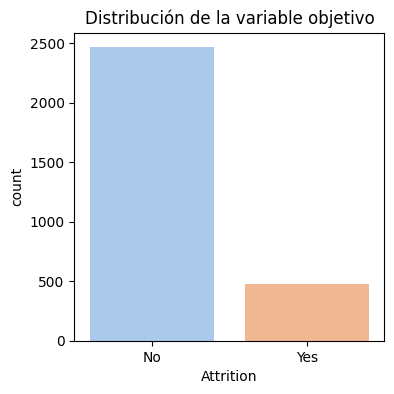

Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


In [476]:
if 'Attrition' in df.columns:
    plt.figure(figsize=(4,4))
    sns.countplot(x='Attrition', data=df, palette='pastel', hue='Attrition', legend=False)
    plt.title("Distribución de la variable objetivo")
    plt.show()
    
    print(df['Attrition'].value_counts(normalize=True) * 100)

8. __Estadísticas descriptivas__

<span style= "color: pink">Estadísticas básicas de las variables numéricas</span>

In [477]:
df.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,2940.000000,2940.000000,2940.000000,2940.000000,2925.000000,2928.000000,2911.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2923.000000,2940.000000,2940.000000,2935.000000,2940.000000,2940.000000,2940.000000,2940.000000
mean,7.343023,12.626871,2.725170,3.150000,2.723077,2.721995,2.758846,36.868707,9.146599,2.903061,2.071769,65335.258503,2.639069,15.166667,0.791837,11.266780,2.787075,7.075170,2.231973,4.155442
std,1.344743,5.473052,0.702384,0.357132,1.095897,1.106817,0.704602,9.053869,8.051168,1.028246,1.104887,47379.053635,2.487355,3.641110,0.848633,7.768597,1.286027,6.205245,3.241121,3.615304
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.285664,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.000000,29040.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.048879,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,2.000000,49385.000000,1.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,8.008627,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,3.000000,83920.000000,4.000000,18.000000,1.000000,15.000000,3.000000,10.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


9. __Visualización de la distribución de variables numéricas__

<span style= "color:pink">Histogramas para visualizar la distribución de las variables numéricas</span>

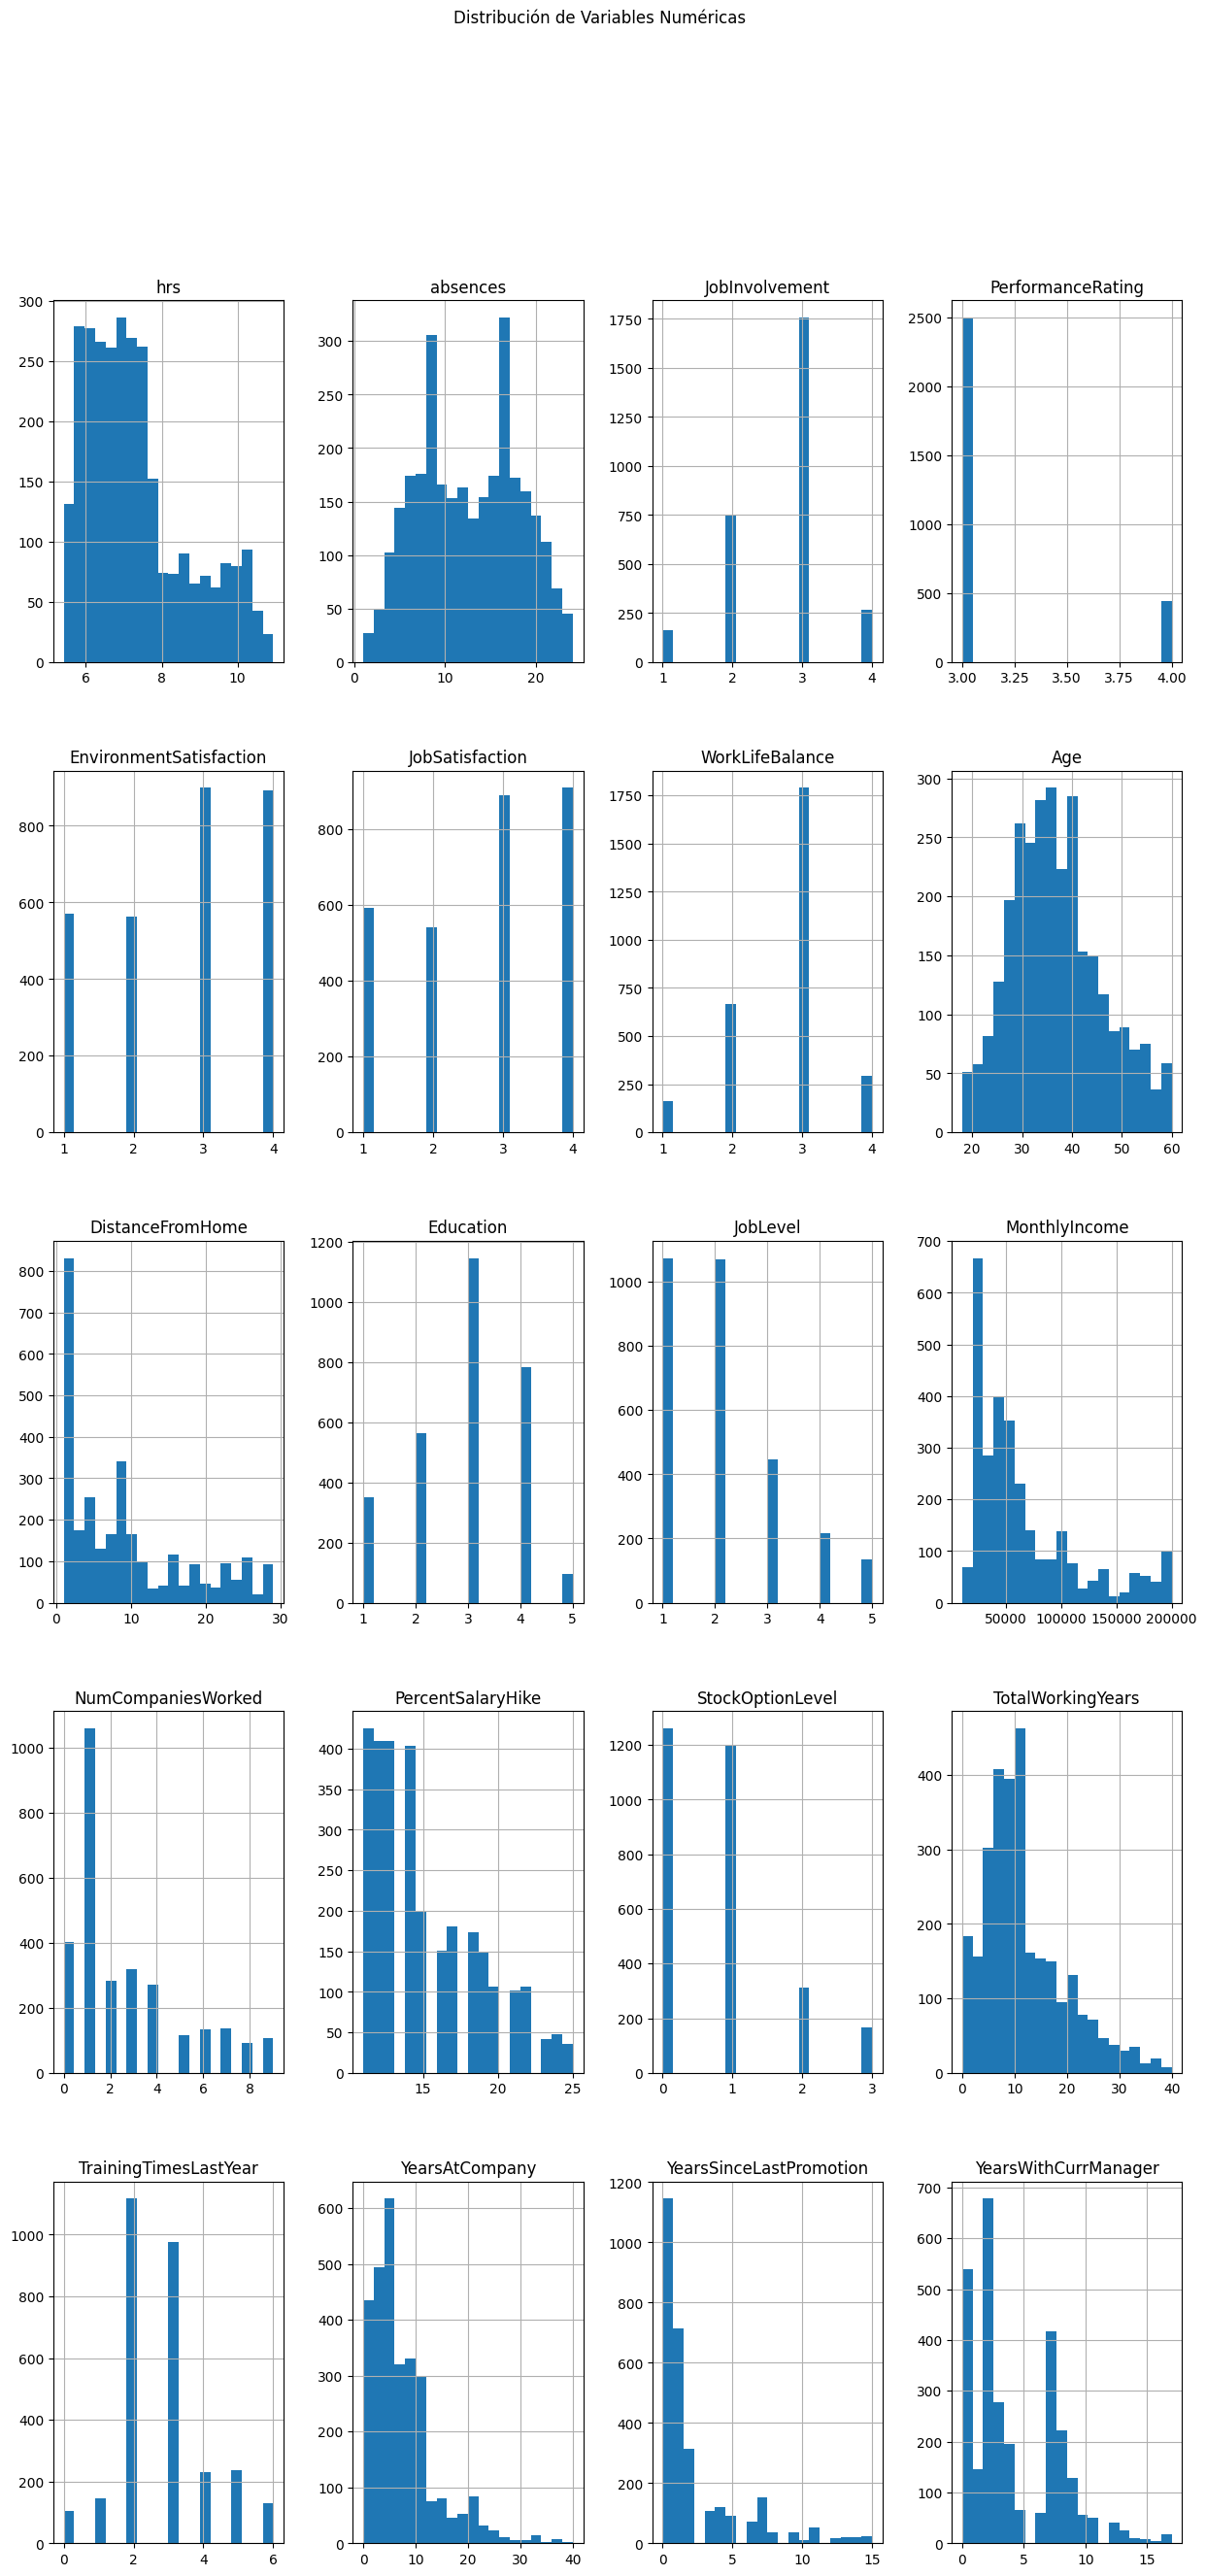

In [478]:

numerical_cols = [col for col in numerical_cols if col in df.columns]

df[numerical_cols].hist(figsize=(15,30), bins=20)
plt.suptitle("Distribución de Variables Numéricas")
plt.show()

# Decidir cómo se va a realizar la evaluación

1.__Configuración de semilla__

In [479]:
RANDOM_STATE = 100474933
np.random.seed(RANDOM_STATE)

2.__Separar variables predictoras y objetivo__

In [480]:
X = df.drop(columns=['Attrition'])
y = df['Attrition']

3.__División en Train/Test manteniendo la proporción de la clase (estratificación)__

In [481]:
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=1/3, random_state=RANDOM_STATE)

<span style= "color:pink"><strong> Filtrar columnas existentes en X_train</strong></span>

In [482]:
numerical_cols = [col for col in numerical_cols if col in X_train.columns]
categorical_cols = [col for col in categorical_cols if col in X_train.columns]
ordinal_cols = [col for col in ordinal_cols if col in X_train.columns]

print(f"Variables categóricas filtradas: {categorical_cols}")
print(f"Variables numéricas filtradas: {numerical_cols}")
print(f"Variables ordinales filtradas: {ordinal_cols}")




Variables categóricas filtradas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
Variables numéricas filtradas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Variables ordinales filtradas: ['Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating']


4.__Pipelines de preprocesamiento__

<li style= "color:pink">Transformación para variables categóricas NO ordinales </li>
<li style= "color:pink">Transformación para variables numéricas</li>
<li style= "color:pink">Transformación para variables ordinales</li>


In [483]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])


5.__Combinación de transformaciones__

In [484]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols),
        ('ord', ord_transformer, ordinal_cols)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['hrs', 'absences', 'JobInvolvement',
                                  'PerformanceRating',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'Age', 'DistanceFromHome',
                                  'Education', 'JobLevel', 'MonthlyIncome',
                                  'NumCompaniesWorked', 'PercentSalaryHike',
                                  'StockOptionLevel', '...
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 ['BusinessTravel', 'Department',
                                  'EducationField', 'Gender', 'JobRole',
                                  'MaritalStatus']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Education', 'JobLevel', 'StockOptionLevel',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'PerformanceRating'])])

6.__Definir pipeline de modelo__

In [485]:
dt_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=100474933))
])

dt_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'Percent...
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Education', 'JobLevel',
                                                   'StockOptionLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=100474933))])

In [486]:
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])
knn_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'Percent...
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Education', 'JobLevel',
                                                   'StockOptionLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating'])])),
                ('classifier', KNeighborsClassifier())])

7.__Evaluación Interna (Inner Evaluation) con Validación Cruzada__

In [487]:
cv_score_dt = cross_val_score(dt_clf, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
print(f"\nBalanced Accuracy (CV) for Decision Tree: {cv_score_dt:.4f}")



Balanced Accuracy (CV) for Decision Tree: 0.7961


In [488]:
cv_score_knn = cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
print(f"\nBalanced Accuracy (CV) for KNN: {cv_score_knn:.4f}")


Balanced Accuracy (CV) for KNN: 0.5923


8.__Entrenar Modelo con el Mejor Setup__

In [489]:
dt_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'Percent...
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Education', 'JobLevel',
                                                   'StockOptionLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=100474933))])

In [490]:
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'Percent...
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Education', 'JobLevel',
                                                   'StockOptionLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating'])])),
                ('classifier', KNeighborsClassifier())])

9.__Evaluación Externa (Outer Evaluation) con el Test Set__

In [491]:
y_pred_dt = dt_clf.predict(X_test)

In [492]:
y_pred_knn = knn_clf.predict(X_test)

10.__Métricas de Evaluación__

In [493]:
bal_acc_dt = balanced_accuracy_score(y_test, y_pred_dt)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"\nDecision Tree - Balanced Accuracy: {bal_acc_dt:.4f}, Accuracy: {acc_dt:.4f}")


Decision Tree - Balanced Accuracy: 0.8305, Accuracy: 0.9000


In [494]:
bal_acc_knn = balanced_accuracy_score(y_test, y_pred_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN - Balanced Accuracy: {bal_acc_knn:.4f}, Accuracy: {acc_knn:.4f}")

KNN - Balanced Accuracy: 0.5869, Accuracy: 0.8388


11.__Calcular TPR y TNR__

In [495]:
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
tn_dt, fp_dt, fn_dt, tp_dt = conf_matrix_dt.ravel()
tpr_dt = tp_dt / (tp_dt + fn_dt)  
tnr_dt = tn_dt / (tn_dt + fp_dt) 


print(f"\n Evaluación Externa (Outer Evaluation)")
print(f"Balanced Accuracy (Test): {bal_acc_dt:.4f}")
print(f"Accuracy (Test): {acc_dt:.4f}")
print(f"True Positive Rate (TPR): {tpr_dt:.4f}")
print(f"True Negative Rate (TNR): {tnr_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))



 Evaluación Externa (Outer Evaluation)
Balanced Accuracy (Test): 0.8305
Accuracy (Test): 0.9000
True Positive Rate (TPR): 0.7278
True Negative Rate (TNR): 0.9331

Classification Report:
               precision    recall  f1-score   support

          No       0.95      0.93      0.94       822
         Yes       0.68      0.73      0.70       158

    accuracy                           0.90       980
   macro avg       0.81      0.83      0.82       980
weighted avg       0.90      0.90      0.90       980



In [496]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
tn_knn, fp_knn, fn_knn, tp_knn = conf_matrix_knn.ravel()
tpr_knn = tp_knn / (tp_knn + fn_knn)  
tnr_knn = tn_knn / (tn_knn + fp_knn)  

print(f"\n Evaluación Externa (Outer Evaluation)")
print(f"Balanced Accuracy (Test): {bal_acc_knn:.4f}")
print(f"Accuracy (Test): {acc_knn:.4f}")
print(f"True Positive Rate (TPR): {tpr_knn:.4f}")
print(f"True Negative Rate (TNR): {tnr_knn:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


 Evaluación Externa (Outer Evaluation)
Balanced Accuracy (Test): 0.5869
Accuracy (Test): 0.8388
True Positive Rate (TPR): 0.2152
True Negative Rate (TNR): 0.9586

Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.96      0.91       822
         Yes       0.50      0.22      0.30       158

    accuracy                           0.84       980
   macro avg       0.68      0.59      0.60       980
weighted avg       0.81      0.84      0.81       980



12.__Matriz de Confusión__

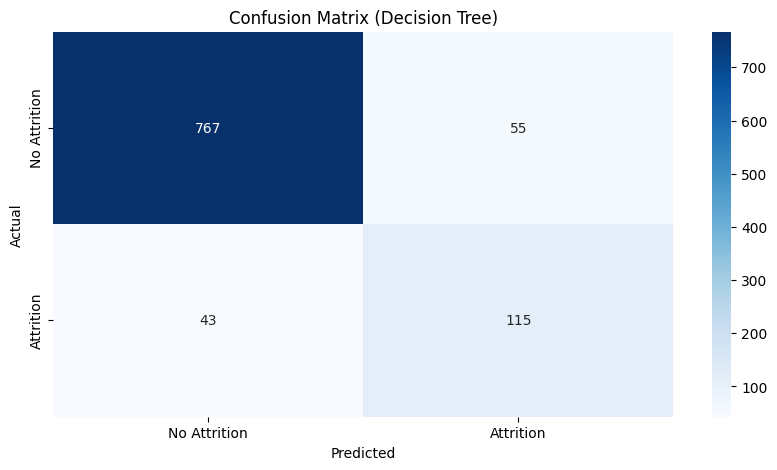

In [497]:
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



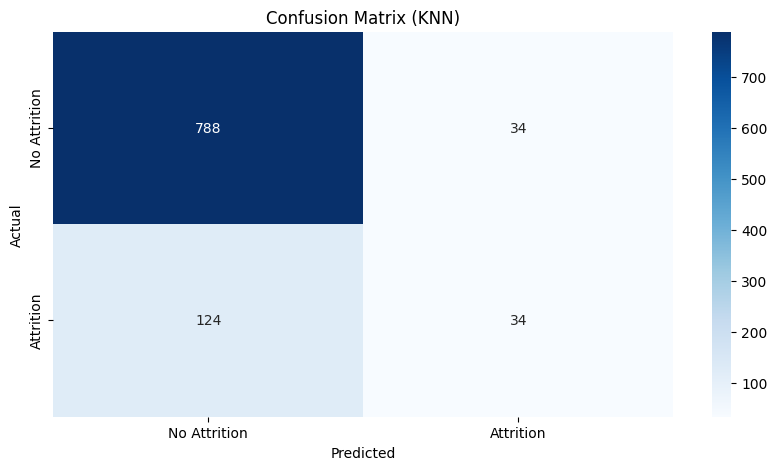

In [498]:
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.title("Confusion Matrix (KNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Métodos básicos: KNN y TREES

1. __Selección del Mejor Método de Escalado e Imputación usando KNN__

<span style= "color:pink"> Definir métodos de escalado y de imputación </span>

In [499]:

scalers = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median')
}

<span style= "color:pink"> Configuración del GridSearch para seleccionar la mejor combinación </span>

In [500]:
param_grid = {
    'preprocessor__num__imputer': list(imputers.values()),
    'preprocessor__num__scaler': list(scalers.values())
}

<span style= "color:pink"> Configuración del GridSearchCV para KNN </span>

In [501]:
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['hrs',
                                                                          'absences',
                                                                          'JobInvolvement',
                                                                          'PerformanceRating',
                                                                          'EnvironmentSatisfaction',
                                                                          'JobSatisfaction',
                                                                          'WorkLifeBalance',
                                                                          'Age',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'JobLevel',
                                                                          'MonthlyIncome',
                                                                          '...
                                                                          'StockOptionLevel',
                                                                          'EnvironmentSatisfaction',
                                                                          'JobSatisfaction',
                                                                          'WorkLifeBalance',
                                                                          'PerformanceRating'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'preprocessor__num__imputer': [SimpleImputer(),
                                                        SimpleImputer(strategy='median')],
                         'preprocessor__num__scaler': [MinMaxScaler(),
                                                       StandardScaler(),
                                                       RobustScaler()]},
             scoring='balanced_accuracy')

<span style= "color:pink">Obtener la mejor combinación de escalado e imputación</span>

In [502]:
best_scaler = [key for key, value in scalers.items() if value == grid_search.best_params_['preprocessor__num__scaler']][0]
best_imputer = [key for key, value in imputers.items() if value == grid_search.best_params_['preprocessor__num__imputer']][0]

print(f"\nMejor escalador: {best_scaler}")
print(f"Mejor método de imputación: {best_imputer}")



Mejor escalador: standard
Mejor método de imputación: median


2. __Evaluación de Modelos con Hiperparámetros por Defecto__

<span style= "color:pink">Definimos los modelos</span>

In [503]:
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
}

<span style= "color:pink">Evaluar el tiempo de entrenamiento y la exactitud con los modelos por omisión</span>

In [504]:
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    start_time = time.time()
    pipeline.fit(X_train, y_train)  
    train_time = time.time() - start_time
    
    y_pred = pipeline.predict(X_test)  
    bal_acc = balanced_accuracy_score(y_test, y_pred) 
    
    print(f"\nModelo: {name}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Tiempo de entrenamiento: {train_time:.4f} segundos")



Modelo: KNN
Balanced Accuracy: 0.5869
Tiempo de entrenamiento: 0.1284 segundos

Modelo: Decision Tree
Balanced Accuracy: 0.8305
Tiempo de entrenamiento: 0.0860 segundos


<span style= "color:pink">Obtener la mejor combinación</span>

In [505]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy con la mejor combinación: {bal_acc:.4f}")

Balanced Accuracy con la mejor combinación: 0.6001


3. __Ajuste de Hiperparámetros (HPO)__

<span style= "color:pink">Definir hiperparámetros a optimizar</span>

In [506]:
param_dist_knn = {
    'n_neighbors': list(range(1, 50, 2)),
    'weights': ['uniform', 'distance']
}

param_dist_tree = {
    'max_depth': list(range(2, 20)),
    'min_samples_split': list(range(2, 50, 5))
}

<span style= "color:pink">RandomizedSearchCV para KNN</span>

In [507]:
search_knn = RandomizedSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    param_distributions={
        'classifier__n_neighbors': param_dist_knn['n_neighbors'],
        'classifier__weights': param_dist_knn['weights']
    },
    n_iter=20,
    cv=5,
    scoring='balanced_accuracy',
    random_state=RANDOM_STATE
)
search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['hrs',
                                                                                'absences',
                                                                                'JobInvolvement',
                                                                                'PerformanceRating',
                                                                                'EnvironmentSatisfaction',
                                                                                'JobSatisfaction',
                                                                                'WorkLifeBalance',
                                                                                'Age',
                                                                                'DistanceFromHome',
                                                                                'Education',
                                                                                'JobLevel',
                                                                                'MonthlyInc...
                                                                                'EnvironmentSatisfaction',
                                                                                'JobSatisfaction',
                                                                                'WorkLifeBalance',
                                                                                'PerformanceRating'])])),
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   n_iter=20,
                   param_distributions={'classifier__n_neighbors': [1, 3, 5, 7,
                                                                    9, 11, 13,
                                                                    15, 17, 19,
                                                                    21, 23, 25,
                                                                    27, 29, 31,
                                                                    33, 35, 37,
                                                                    39, 41, 43,
                                                                    45, 47,
                                                                    49],
                                        'classifier__weights': ['uniform',
                                                                'distance']},
                   random_state=100474933, scoring='balanced_accuracy')

<span style= "color:pink">RandomizedSearchCV para Árboles</span>

In [509]:
search_tree = RandomizedSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]),
    param_distributions={
        'classifier__max_depth': param_dist_tree['max_depth'],
        'classifier__min_samples_split': param_dist_tree['min_samples_split']
    },
    n_iter=20,
    cv=5,
    scoring='balanced_accuracy',
    random_state=RANDOM_STATE
)
search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['hrs',
                                                                                'absences',
                                                                                'JobInvolvement',
                                                                                'PerformanceRating',
                                                                                'EnvironmentSatisfaction',
                                                                                'JobSatisfaction',
                                                                                'WorkLifeBalance',
                                                                                'Age',
                                                                                'DistanceFromHome',
                                                                                'Education',
                                                                                'JobLevel',
                                                                                'MonthlyInc...
                                                                                'StockOptionLevel',
                                                                                'EnvironmentSatisfaction',
                                                                                'JobSatisfaction',
                                                                                'WorkLifeBalance',
                                                                                'PerformanceRating'])])),
                                             ('classifier',
                                              DecisionTreeClassifier())]),
                   n_iter=20,
                   param_distributions={'classifier__max_depth': [2, 3, 4, 5, 6,
                                                                  7, 8, 9, 10,
                                                                  11, 12, 13,
                                                                  14, 15, 16,
                                                                  17, 18, 19],
                                        'classifier__min_samples_split': [2, 7,
                                                                          12,
                                                                          17,
                                                                          22,
                                                                          27,
                                                                          32,
                                                                          37,
                                                                          42,
                                                                          47]},
                   random_state=100474933, scoring='balanced_accuracy')

<span style= "color:pink">Mostrar mejores parámetros y resultados</span>

In [510]:
print(f"\n Mejor KNN: {search_knn.best_params_}, Balanced Accuracy: {search_knn.best_score_:.4f}")
print(f" Mejor Árbol: {search_tree.best_params_}, Balanced Accuracy: {search_tree.best_score_:.4f}")


 Mejor KNN: {'classifier__weights': 'distance', 'classifier__n_neighbors': 1}, Balanced Accuracy: 0.8230
 Mejor Árbol: {'classifier__min_samples_split': 7, 'classifier__max_depth': 18}, Balanced Accuracy: 0.7622
